# **ORB Feature Matcher**

This notebook walks you through how ORB works and how it's used to filter out unrelated input images before building a 3D mesh.

---

### 🔍 What is ORB?

- ORB (Oriented FAST and Rotated BRIEF) is a lightweight, real-time feature detection method. It’s optimized for speed and low memory usage—perfect for fast image filtering.  
- Bonus: it’s open-source and free from licensing restrictions (unlike SIFT or SURF).


### 🤔 Why Do We Need ORB?

- When uploading input images, it’s easy to accidentally include an unrelated one (say, a photo of your cat). That could break your mesh reconstruction.
- ORB compares key visual features and filters out mismatches—so your model only sees what matters.


### ⚙️ How Does ORB Work?

- Even if your images have different angles, lighting, or devices, ORB can detect shared patterns across them.
- It uses FAST to find keypoints, Harris scoring to rank them, and BRIEF (with rotation invariance) to describe them.
- That way, ORB preserves the real-world structure and ignores the visual noise.

**P.S.** If you want to dive deeper into how ORB compares to SIFT and SURF? Check out this article [A Comparison of SIFT, SURF, and ORB on OpenCV](https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0)

---

### 🧪 Time to Put It to the Test!

We’re going to explore how ORB works step by step, and then implement our own `orb_matcher` to filter the images. Here’s the plan:

1. Check the images  
2. Detect keypoints using FAST  
3. Rank keypoints with Harris score
4. Orient the keypoints  
5. Compute descriptors using ORB (Rotated BRIEF)  
6. Match keypoints between images
7. How to Filter Image Pairs by Match Quality
8. Filter Method & Results 

## **1. Check the images**

---

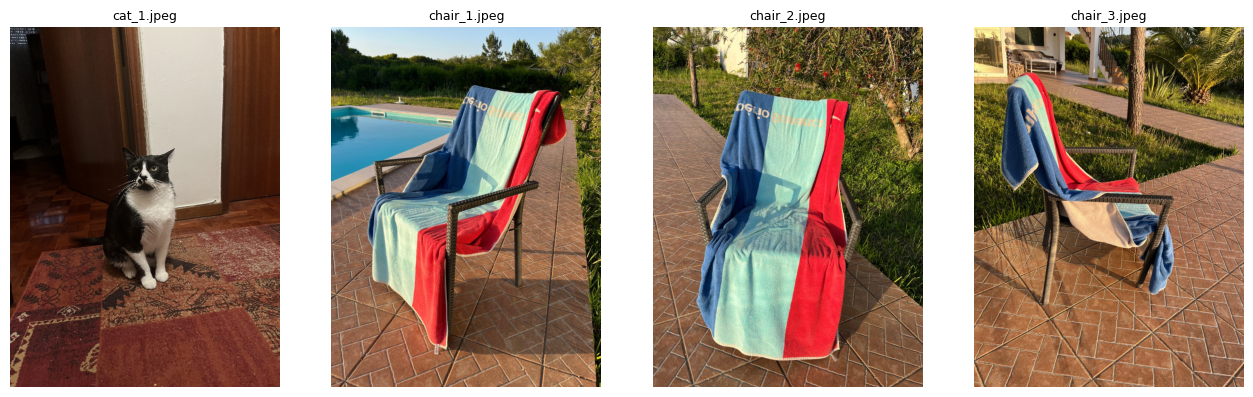

In [3]:
import os
import random
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

# Set seed for result reproducibility
random.seed(32)

# Path to the images
test_dir = '../test_images'
image_set_1_dir = os.path.join(test_dir, 'image_set_1')
image_files = sorted([f for f in os.listdir(image_set_1_dir) if f.endswith('.jpeg')])

# Read the images in RGB to display & in grayscale for FAST keypoint detection
img_dict = {}
gray_img_dict = {}
for img_name in image_files:
    path = os.path.join(image_set_1_dir, img_name)

    # Read RGB
    img = cv.imread(path, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (600, 800)) # Resize to avoid long computation time
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for matplotlib
    img_dict[img_name] = img_rgb # Associate filename with respective image

    # Read grayscale
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (600, 800)) # Resize to avoid long computation time
    gray_img_dict[img_name] = img

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

> I’ve got 3 images of a chair with a towel that I want to mesh for my game. But while feeding them into the program, **I accidentally tossed in a photo of my cat... Let’s see how ORB reacts.**

## **2. Detect Keypoints using FAST**

---

### What is FAST?

Before ORB can compare images, it needs to find the keypoints, distinctive spots in each image, like corners or textured regions.

To do that quickly, it uses **FAST (Features from Accelerated Segment Test)**, a super fast algorithm designed for real-time detection with minimal computation. It gives us a rough but efficient set of feature candidates to work with.

Here's how it works:

- It checks a circle of pixels around each one in the image.
- If a certain number of those pixels are much brighter or darker than the center, it marks it as a keypoint.
- It skips boring, flat areas and finds areas with contrast, which are useful for matching later.

### Why FAST?

- **Speed**: It’s designed to be *fast*, making it great for real-time use.
- **Efficiency**: It quickly gives us lots of potential features to work with.

### Any downsides?

FAST keypoints are just points (x, y) — they don’t have **orientation** or **scale** info.  
This means they can break under rotation or zoom.

But don’t worry, we’ll fix that in the next steps using ORB!

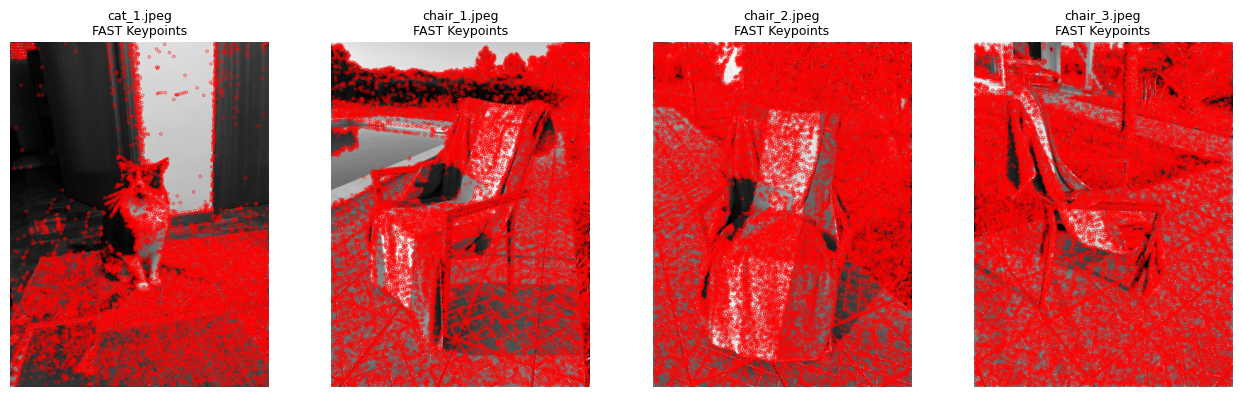

In [4]:
# Initialize FAST detector instance
fast = cv.FastFeatureDetector_create()

# Detect keypoints for each image & draw them on the images
keypoints_dict = {}
img_dict_kp = {}
for img_name, gray_img in gray_img_dict.items():
    kp = fast.detect(gray_img, None) # Detect keypoints
    keypoints_dict[img_name] = kp

    img_kp = cv.drawKeypoints(gray_img, kp, None, color=(255, 0, 0)) # Draw keypoints on the image
    img_dict_kp[img_name] = img_kp

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_dict_kp.items()):
    ax.imshow(img)
    ax.set_title(f'{img_name}\nFAST Keypoints', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **3. Rank Keypoints using Harris Score**

---

Now that we've found a bunch of potential keypoints with FAST, it's time to figure out which ones are actually useful.

FAST is fast (as the name says), but it's not picky - **it may detect too many weak or unstable points as we can see in the chair pictures**. To refine our selection, we score each keypoint using the Harris corner measure, which tells us how corner-like a point is (strong corners = better features).

By ranking all the detected points with this score, we can keep only the top keypoints that are most likely to be stable and distinctive—ideal for matching across images.


### What is the Harris Score?


Now that we've found a bunch of potential keypoints with FAST, it's time to figure out which ones are actually useful. FAST is fast (as the name says), but it's not picky, **it may detect too many weak or unstable points as we can see in the chair pictures**. 

To refine our selection, we need a way to **rank** them, not all corners are equally useful. **Harris Score** helps us measure how 'strong' or 'distinctive' each keypoint is.

### How does it work?

- It looks at how much the image changes around a keypoint in different directions.
- Strong corners (like where two edges meet) give **high scores**.
- Flat areas or edges alone get **low scores**.

### Why rank?

FAST can give **too many** keypoints — some are noisy or weak.

By ranking all the detected points with this score, we can keep only the top keypoints that are most likely to be stable and distinctive ideal for matching multiple images.

### In short:

Harris Score says:  
> “Let’s sort these keypoints and keep only the strongest, most interesting ones.”

That way, we avoid wasting time matching weak or useless features!

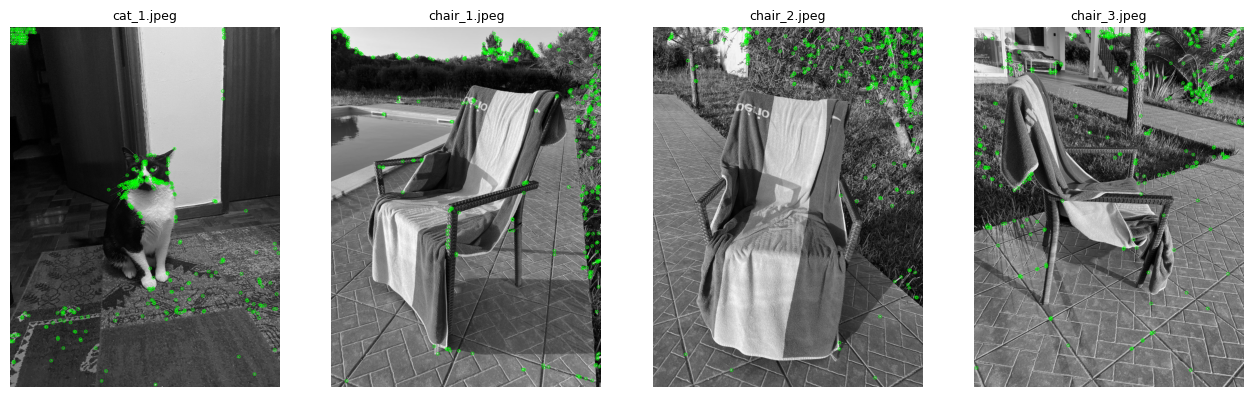

In [5]:
def harris_rank_kp(
        img: np.array, keypoints: list[cv.KeyPoint], top_k: int = 100
) -> list[cv.KeyPoint]:
    '''
    Evaluates keypoints importance by computing Harris corner strength
    for each and selects the top K most distinctive ones.
    
    Params:
        img (np.ndarray): Grayscale image.
        keypoints (list[cv.KeyPoint]): Keypoints detected by a feature detector (e.g. FAST).
        top_k (int): Number of top keypoints to return (default is 50).

    Returns: 
        list[cv.KeyPoint]: Top ranked keypoints based on Harris response.
    '''
    # Convert image to float32 for corner Harris
    gray = np.float32(img)

    # Compute Harris corner response
    harris_response = cv.cornerHarris(gray, blockSize = 2, ksize = 3, k = 0.04)
    harris_response = cv.dilate(harris_response, None) # Dilate results for marking the corners (not important)

    # Normalize the Harris response map (optional but useful for visualization or debugging)
    harris_response = cv.normalize(harris_response, None, 0, 255, cv.NORM_MINMAX)

    # Get Harris score for each keypoint
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if 0 <= y < harris_response.shape[0] and 0 <= x < harris_response.shape[1]:
            kp.response = harris_response[y, x]
        else:
            kp.response = 0  # Out of bounds safeguard

    # Sort by Harris response (descending) and return top K keypoints
    keypoints_sorted = sorted(keypoints, key = lambda x: x.response, reverse=True)

    return keypoints_sorted[:top_k]

# Rank and draw top k keypoints for each image
top_k = 350
top_kp_dict = {}
for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    top_kp = harris_rank_kp(gray_img, kp, top_k) # Rank keypoints

    top_kp_img = cv.drawKeypoints(gray_img, top_kp, None, color=(0, 255, 0)) # Draw top keypoints on the image
    top_kp_dict[img_name] = top_kp_img

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, top_kp_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **4. Orient the Keypoints**

---

So far, we've used **FAST** to quickly detect points of interest (called **keypoints**) in each image. Then we used **Harris Corner Score** to pick the strongest ones.

But here's the thing:

> Those keypoints are just **x, y positions** — they don't know which way they're 'facing'.

That's a problem when we're comparing images that might be rotated.  
For example, two photos of the same object:

- One taken normally
- Another tilted 90°

Without orientation, those points won't line up — even if they're the same spot in the real world.

That's where ORB steps in again, giving each keypoint a **direction** based on its surrounding pixels, like telling it,  
> 'Hey, remember which way you're pointing!'

This makes our matching **rotation invariant**, so even if the image is flipped or turned, we can still recognize the same features.

Let’s add orientation to our keypoints!

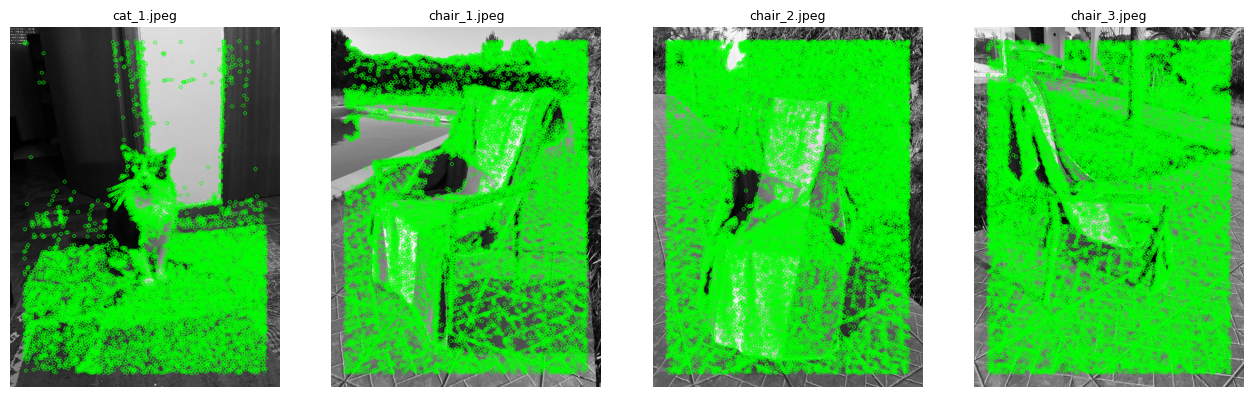

In [6]:
# Initialize ORB instance
orb = cv.ORB_create()

# Compute orientation for each image's keypoints & draw them with orientation arrows
kp_dict = {}
img_oriented_kp_dict = {}

for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    oriented_kp = orb.compute(gray_img, kp)[0] # Compute orientation
    kp_dict[img_name] = oriented_kp

    img_kp_oriented = cv.drawKeypoints(gray_img, oriented_kp, None, color=(0, 255, 0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    img_oriented_kp_dict[img_name] = img_kp_oriented

# Plot
fig, axs = plt.subplots(1, len(img_dict), figsize=(13, 4))
for ax, (img_name, img) in zip(axs, img_oriented_kp_dict.items()):
    ax.imshow(img)
    ax.set_title(img_name, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## **5. Describe Keypoints with Rotated BRIEF (ORB)**

---

### What is BRIEF?

**BRIEF** stands for *Binary Robust Independent Elementary Features*.

It creates a compact **binary string** (like `101001...`) to describe what's around a keypoint, sort of like a fingerprint.

Here’s how it works:

- It picks random pairs of pixels in a small patch around the keypoint.
- If one pixel is brighter than the other, it writes a `1`, otherwise a `0`.
- After doing this many times, you get a unique string of 0s and 1s, **a descriptor**.

**This is fast, simple, and great for comparing features. But BRIEF has a problem, it’s not rotation invariant**.
That means if an object is upright in one image and rotated in another, BRIEF might describe the same keypoint *very differently*.  
This makes matching unreliable when images are taken at different angles.

### ORB Fixes That by Rotating the Patch

ORB improves BRIEF by aligning the patch **based on the keypoint's orientation** (which we calculated earlier).

Here's the idea:

> 🧭 'Let me rotate the image patch around the keypoint so it always faces the same direction, **then** I’ll apply BRIEF.'

This rotation step makes the descriptors **rotation invariant**!  
So now, even if the same object appears tilted, flipped, or spun, ORB still gives similar descriptors.

### In Short:

> 'Let me figure out which way this keypoint is pointing...  
> Now I'll rotate the area around it...  
> Then I'll describe it.'

Thanks to this trick, ORB can match features across rotated images with much higher accuracy.

In [7]:
# Compute rotated BRIEF descriptors for each image's keypoints & draw them
descriptors_dict = {}

for img_name, gray_img in gray_img_dict.items():
    kp = keypoints_dict[img_name]
    descriptors = orb.compute(gray_img, kp)[1] # Compute rotated BRIEF descriptors

    descriptors_dict[img_name] = descriptors

## **6. Match keypoints between images**

---

Now that we have descriptors for each keypoint, we can **match** them across images.

We do this using **Hamming distance**, which tells us how similar two binary strings are.

### What is Hamming Distance?

Hamming distance is a way to compare two binary strings, simply counting how many bits are different between them.

> For example:
>
> `101010` vs `100110` <br>
> Since 2 bits are different, it means Hamming distance = 2

---

Now let's combine all the previous steps and perform image matching.

*Note: To keep the output clean, only one image pair will be displayed as an example.*

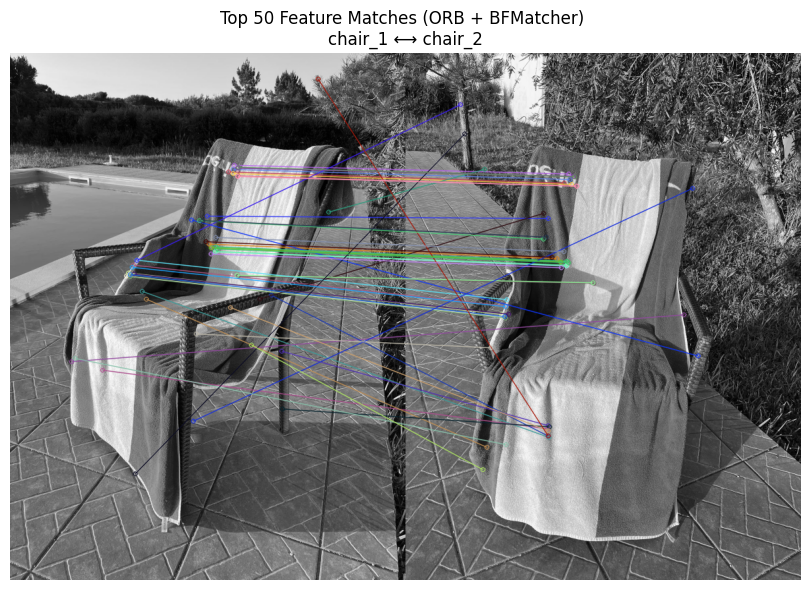

In [8]:
def bf_orb_img_matcher(
        image_dir: str, max_orb_nfeatures: int = 1000, top_k: int = 50, thresholds: list[int] = list(range(10, 100, 5))
) -> dict:
    '''
    Performs pairwise Brute-Force matching using ORB descriptors on a set of images in a directory.

    Params:
        image_dir (str): Directory containing the input images (relative to '../test_images').
        max_orb_nfeatures (int): Maximum number of ORB features to retain per image (default: 1000).
        top_k (int): Number of top matches to draw for each image pair (default: 50).
        thresholds (list[int]): List of Hamming distance thresholds to evaluate match quality 
                                (default: [10, 15, ..., 95]).

    Returns:
        dict[str, dict[str, Any]]: A dictionary where each key is an image pair label (e.g., 'img1 ⟷ img2'), and the value is a dictionary with:
            - 'distances' (list[float]): All Hamming distances of matches between the image pair.
            - 'match_per_dist_counts' (list[int]): Number of matches below each threshold.
            - 'matched_img' (np.ndarray): Image showing the top_k matches drawn between the image pair.
    '''
    # Path to the images
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpeg')])

    # Read in grayscale for FAST keypoint detection
    gray_img_dict = {}
    for img_name in image_files:
        path = os.path.join(image_dir, img_name)
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (600, 800)) # Resize to avoid long computation time
        gray_img_dict[img_name] = img

    # Initiate ORB detector
    orb = cv.ORB_create(nfeatures=max_orb_nfeatures)

    # create BFMatcher object
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)

    # Match al images pairwise
    matched_img_dict = {}
    for (img_name_1, img_1), (img_name_2, img_2) in combinations(gray_img_dict.items(), 2):

        # Current combination
        combo = f'{img_name_1} ⟷ {img_name_2}'
        combo = combo.replace('.jpeg', '') # Clean the names

        # Compute the keypoints and descriptors with ORB
        kp_1, des_1 = orb.detectAndCompute(img_1, None)
        kp_2, des_2 = orb.detectAndCompute(img_2, None)

        # Match descriptors
        matches = bf.match(des_1, des_2)

        # Sort matches in the order of their distance
        sorted_matches = sorted(matches, key = lambda x: x.distance)

        # Draw top K matches
        matched_img = cv.drawMatches(
            img_1, kp_1,
            img_2, kp_2,
            sorted_matches[:top_k], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Get distances for each match
        distances = [m.distance for m in matches]

        # Count good matches for each hamming distance threshold (for later plot)
        match_per_dist_counts = [
            len([m for m in matches if m.distance < t])
            for t in thresholds
        ]
        
        # Save results
        matched_img_dict[combo] = {
            'distances': distances,
            'match_per_dist_counts': match_per_dist_counts, 
            'matched_img': matched_img
        }

    return matched_img_dict

# Hamming distance thresholds
thresholds = list(range(10, 100, 5))

# Number of top matches to draw
top_k = 50

# Matching images
matched_img_dict = bf_orb_img_matcher(
    image_dir=image_set_1_dir, max_orb_nfeatures=50_000,top_k=top_k, thresholds=thresholds
)

# Plot
plot_combination = 'chair_1 ⟷ chair_2'
plt.figure(figsize=(14, 6))
plt.title(f'Top {top_k} Feature Matches (ORB + BFMatcher) \n{plot_combination}')
plt.imshow(matched_img_dict[plot_combination]['matched_img'])
plt.axis('off')

plt.tight_layout()
plt.show()

### **7. How to Filter Image Pairs by Match Quality**

---

When working with mixed image sets (like in this example, where a cat image doesn’t belong with the chair images), how can we **measure match quality** between image pairs?

One useful method is to analyze the **distribution of feature match distances**, which helps us understand how similar or dissimilar two images are, based on their visual features.

### How to Read These Histograms

Each histogram shows how *good or poor* the feature matches are between a pair of images, based on the **Hamming distance**.

- **X-axis:** Hamming distance (lower is better)  
- **Y-axis:** Number of matches at each distance

#### Interpretation Guide:

- **Left side (20–50):**  
  **Strong matches** — descriptors are very similar. These are high-quality matches to keep.

- **Middle (50–70):**  
  **Moderate matches** — somewhat similar, possibly noisy or partially correct.

- **Right side (70–100):**  
  **Weak matches** — likely incorrect. Good candidates to discard.

Use the histogram to choose a reasonable **cutoff threshold** — e.g., keeping only matches with a distance less than 65.

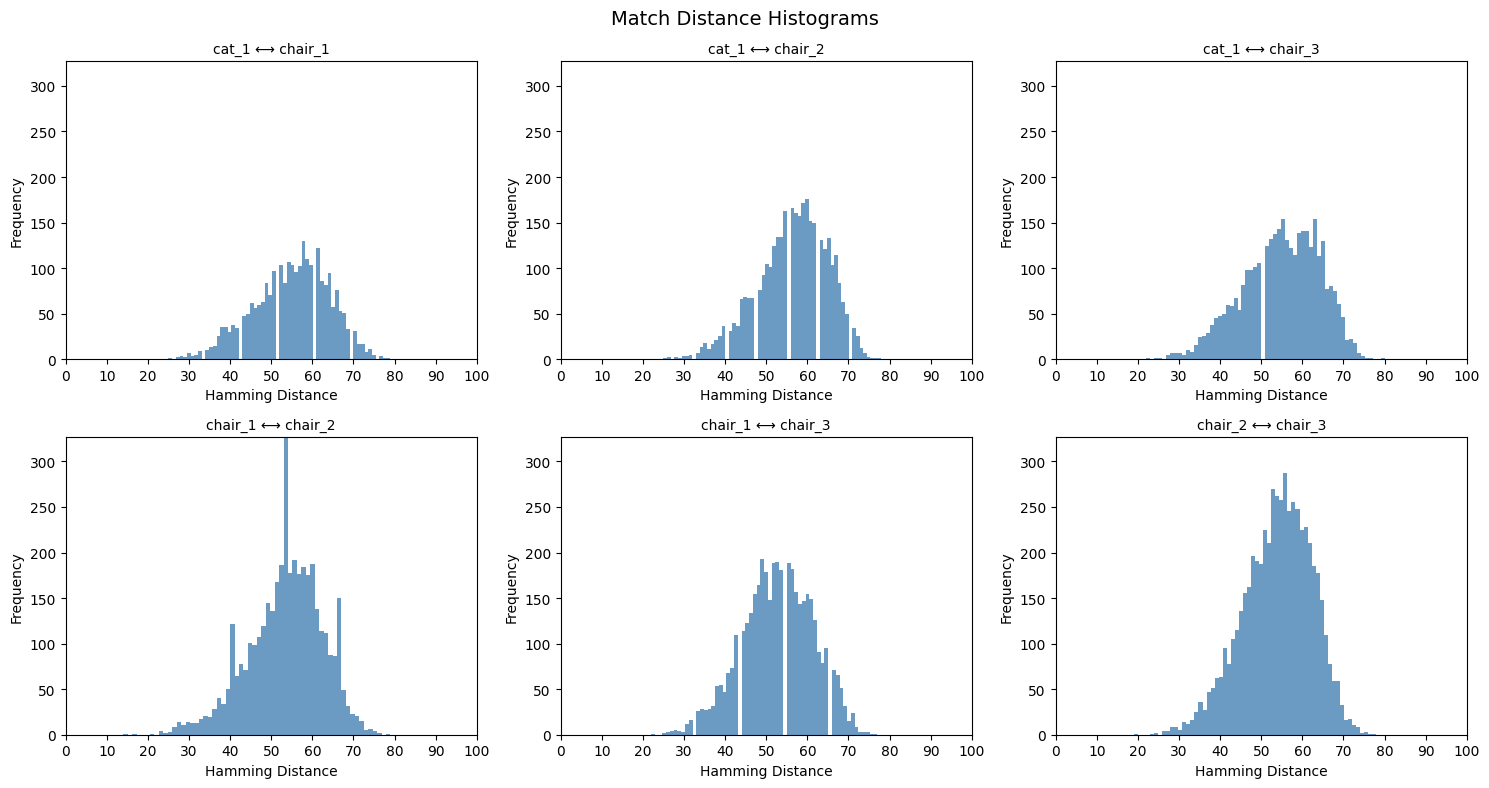

In [9]:
# Plot config
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  
axs = axs.flatten()

# Get highest distance frequency from all combos (for Plot config)
highest_freq = 0
for combo_results in matched_img_dict.values():
    current_distances = combo_results['distances']
    counter = Counter(current_distances) # Count frequency
    current_highest_freq = counter.most_common(1)[0][1]

    if current_highest_freq > highest_freq:
        highest_freq = current_highest_freq

for i, (combo, combo_results) in enumerate(matched_img_dict.items()):

    # Get the matches hamming distance for current combo
    current_distances = combo_results['distances']

    # Plot
    ax = axs[i]
    ax.hist(current_distances, bins=60, color='steelblue', alpha=0.8)
    ax.set_title(f'{combo}', fontsize=10)
    ax.set_ylim(0, highest_freq+40)
    ax.set_xticks(range(0, 110, 10))
    ax.set_xlabel('Hamming Distance')
    ax.set_ylabel('Frequency')

# Plot layout
plt.suptitle('Match Distance Histograms', fontsize=14)
plt.tight_layout()
plt.show()

### **Interpreting the Match Distance Histograms**

The top row of histograms compares the **cat image** with each of the **chair images**. The bottom row shows all combinations between **chair images**.

#### **Top Row: Cat ⟷ Chair Comparisons**

- Had less matches, so N matches could be a filter.
- Distributions are wider, with many matches in the 55–75+ range.
- There are few strong matches (under 50), suggesting weak feature alignment.
- Peaks appear at higher distances, which typically indicate noisy or poor matches.
- This tells us the cat image **does not share consistent visual features** with the chairs.

#### **Bottom Row: Chair ⟷ Chair Comparisons**

- Distributions are narrower, with clear peaks around 50–60.
- Many more matches fall in the 50–65 range, suggesting better feature similarity.
- There's a higher concentration of strong and average matches, and fewer weak ones.

#### **Current Conclusion**

These histograms clearly support that:
- The **cat image is an outlier**, matching poorly with the chairs.
- The **chair images match each other quite well**, and can be grouped confidently.

A reasonable/slightly strict **cutoff threshold based on the histogram results could 60**.

---

Other way to select or to support the threshold definition, is to plot how many "good matches" we get when we change the **strictness** of what we consider a good match.

### How to Read These Charts

Each line chart tells us how the number of matches grows as we relax the distance threshold, helping us **pick a cutoff** for filtering weak matches.

While the X-axis shows the hamming distance threshold we're considering, the Y-axis shows how many matches could considered "good" (i.e., had a distance less than the value on the X-axis).

For example:
- At 30, we're saying “only accept very close (strict) matches.”  
- At 70, we’re saying “I’ll also accept looser (less accurate) matches.”

This helps us decide:

- ✅ Which image pairs have strong matching features  
- ❌ Which pairs might not belong to the same group

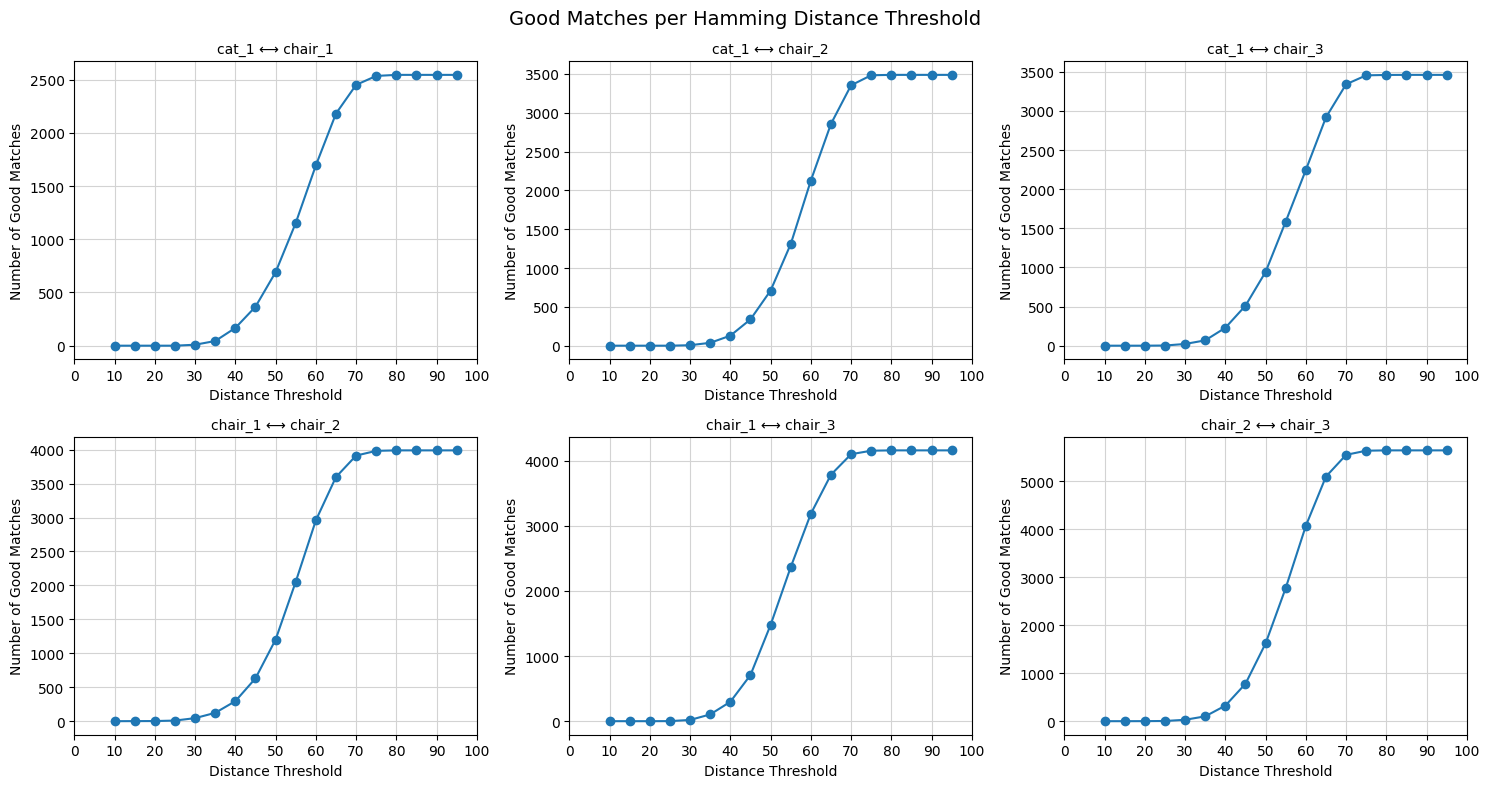

In [10]:
# Plot config
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  
axs = axs.flatten()

for i, (combo, combo_results) in enumerate(matched_img_dict.items()):

    # Get the matches count per threshold for current combo
    current_match_per_dist_match = combo_results['match_per_dist_counts']

    # Plot
    ax = axs[i]
    ax.plot(thresholds, current_match_per_dist_match, marker='o')
    ax.set_title(f'{combo}', fontsize=10)
    ax.set_xticks(range(0, 110, 10))
    ax.set_xlabel('Distance Threshold')
    ax.set_ylabel('Number of Good Matches')
    ax.grid(True, color='lightgray')

# Plot layout
plt.suptitle('Good Matches per Hamming Distance Threshold', fontsize=14)
plt.tight_layout()
plt.show()

### **Interpreting the Good Match Line Charts**

- As expected, **combinations with the cat had less number of good matches**.
- **From 20 to 30, the number of matches is very low**. Why? Because not many matches are that perfect.
- **From ~40 to 70, there's a sharp rise**, this means many matches are in that "pretty good" range.
- **After 70, the curve flattens out**, meaning you’re not gaining many new good matches, just worse ones.

**Since most good ORB matches in our image pair are clustered between 50 and 70, a threshold around 60 seems fit. Despite being a little strict,  confirming the results from the histograms**.
<br>
<br>
<br>

### **8. Filtering Methods & Evaluation**

---

For a human, spotting the "odd one out" in a set of images (like identifying the misplaced cat among chairs) is straightforward, thanks to our cognitive abilities and contextual understanding.

However, for a computer, this task is more complex. It must rely solely on visual patterns and feature descriptors, without any inherent understanding of object categories. Things get trickier when, for example, more than one cat image is introduced into the set.

In this chapter, we'll explore how different **filtering methods** perform across a range of test scenarios:

- (3 chairs, 1 cat)  
- (3 chairs, 2 cats)  
- (3 chairs, 3 cats)

This last scenario (3 chairs, 3 cats), it's an **extreme stress test** for the filtering method. By introducing multiple distractor images, we push the method to its limits and evaluate its **robustness**.

Our goal is to evaluate how well each method distinguishes similar images (chairs) from dissimilar ones (cats), and to determine which approach provides the most consistent and interpretable results.

---

### The Good Matches Ratio Plot

A plot designed to define a threshold that filters images with poor Good Matches Ratio with the others.

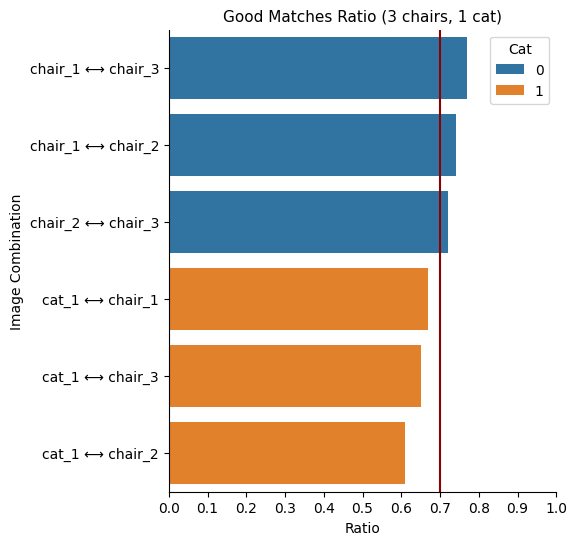

In [11]:
def results_df(
    matched_img: dict, hamming_threshold: int, 
) -> pd.DataFrame:
    '''
    Generates a summary DataFrame of ORB match statistics for each image pair.

    Args:
        matched_img_dict (dict): Output dictionary from the `bf_orb_img_matcher` function, 
                                containing match data for each image pair.
        hamming_threshold (int): Hamming distance threshold to define a 'good' match.

    Returns:
        pd.DataFrame: A DataFrame with one row per image pair, containing:
            - 'Image_Combo': Name of the image pair (e.g., 'img1 ⟷ img2').
            - 'N_Total_Matches': Total number of ORB matches between the pair.
            - 'N_Good_Matches': Number of matches with Hamming distance below the threshold.
            - 'Good_Matches_Ratio': Proportion of good matches, rounded to two decimals.
    '''
    combo_list = []
    n_matches_list = []
    good_matches_list = []
    good_match_ratio_list = []
    for combo, combo_results in matched_img.items():

        # Get total number of ORB matches (same as number of distances)
        n_matches = len(combo_results['distances'])

        # Get the total number of good matches according to the threshold
        good_matches = len([d for d in combo_results['distances'] if d < hamming_threshold])  

        # Get good match ratio
        good_match_ratio = np.round(good_matches / n_matches, 2)

        # Store results
        combo_list.append(combo)
        n_matches_list.append(n_matches)
        good_matches_list.append(good_matches)
        good_match_ratio_list.append(good_match_ratio)

    # Create DataFrame 
    df = pd.DataFrame(
        {
            'Image_Combo': combo_list,
            'N_Total_Matches': n_matches_list,
            'N_Good_Matches': good_matches_list,
            'Good_Matches_Ratio': good_match_ratio_list
        }
    )
    return df.sort_values(by='Good_Matches_Ratio', ascending=False)

# Define hamming distance threshold
HAMMING_THRESHOLD = 60

# Get results dataframe
df_set_1 = results_df(matched_img=matched_img_dict, hamming_threshold=HAMMING_THRESHOLD)

# Creating feature to separate observation with cat results
df_set_1['Cat'] = df_set_1.Image_Combo.apply(lambda x: 1 if 'cat' in x.lower() else 0)

# Plot
fig, ax = plt.subplots(figsize=(5, 6))
sns.barplot(
    data=df_set_1,
    x='Good_Matches_Ratio',
    y='Image_Combo',
    hue='Cat',
    ax=ax     
)
ax.set_title('Good Matches Ratio (3 chairs, 1 cat)', fontsize=11)
ax.set_ylabel('Image Combination')
ax.set_xlabel('Ratio')
ax.set_xticks([i / 10 for i in range(0, 11)])
ax.spines[['right', 'top']].set_visible(False)

plt.axvline(x=0.7, color='darkred')
plt.show()

### Interpreting the Good Matches Ratio Plot

Looking at the plot, we can see that **setting a threshold at 0.7** successfully separates the cat image from the chair group, all chair-to-chair combinations are above this line, while the cat-to-chair combinations fall below it.

This is the **desired behavior**: filtering out mismatched images based on low match quality.

**However, this result is case-specific**. The 0.7 threshold works well in this particular subset with **only one cat image**.

But what if we added **two cat images** instead? In that case, cat-to-cat matches might show a higher similarity (e.g., a ratio above 0.7), which could cause the filter to **mistakenly group them together** or even **retain them**.

This demonstrates that while the **Good Matches Ratio** is a useful indicator, it may not generalize well without further context or dynamic thresholding based on the dataset composition.

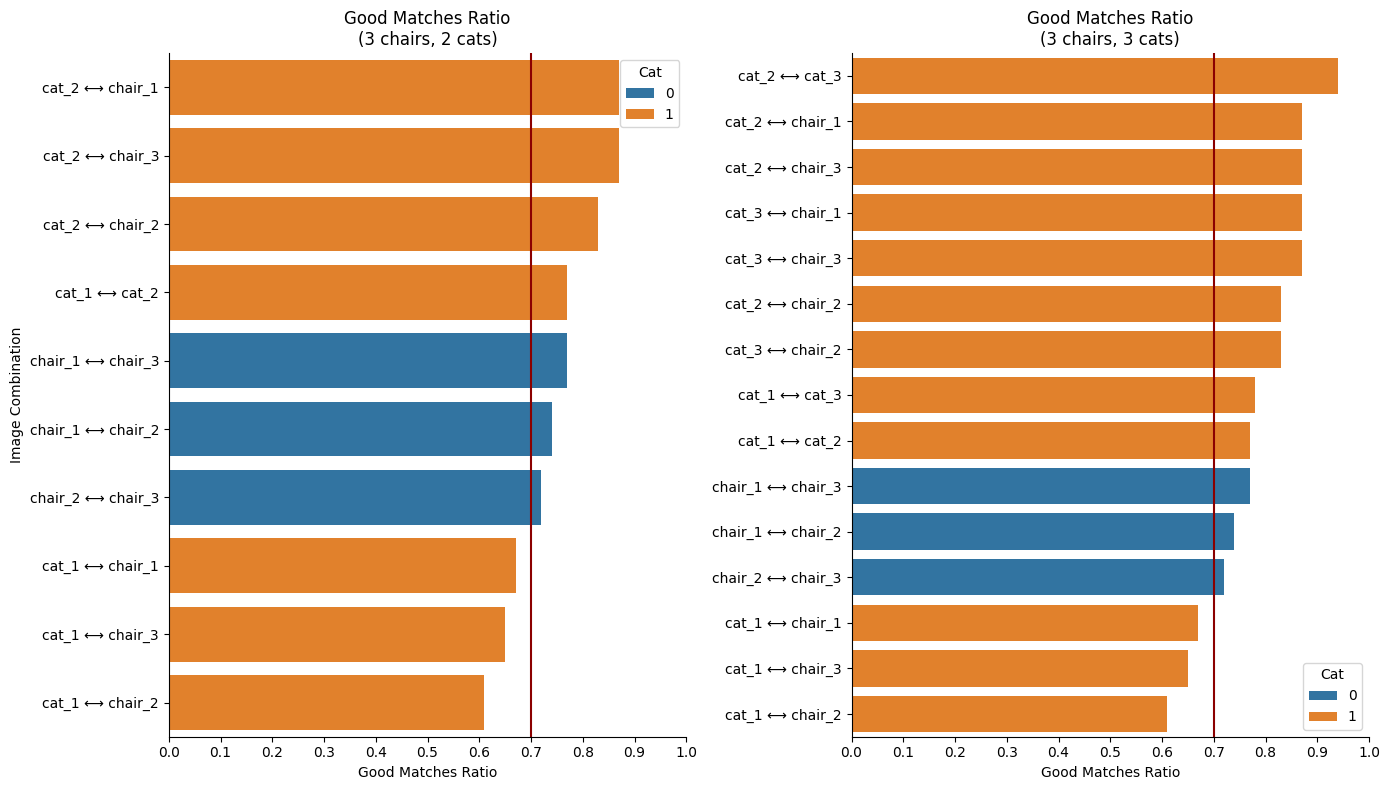

In [12]:
# Path to new sets of images
image_set_2_dir = os.path.join(test_dir, 'image_set_2')
image_set_3_dir = os.path.join(test_dir, 'image_set_3')

# Matching images
matched_img_dict_set_2 = bf_orb_img_matcher(
    image_dir=image_set_2_dir, max_orb_nfeatures=50_000,top_k=top_k, thresholds=thresholds
)

matched_img_dict_set_3 = bf_orb_img_matcher(
    image_dir=image_set_3_dir, max_orb_nfeatures=50_000,top_k=top_k, thresholds=thresholds
)

# Get results dataframe
df_set_2 = results_df(matched_img=matched_img_dict_set_2, hamming_threshold=HAMMING_THRESHOLD)
df_set_3 = results_df(matched_img=matched_img_dict_set_3, hamming_threshold=HAMMING_THRESHOLD)

# Creating feature to separate observation with cat results
df_set_2['Cat'] = df_set_2.Image_Combo.apply(lambda x: 1 if 'cat' in x.lower() else 0)
df_set_3['Cat'] = df_set_3.Image_Combo.apply(lambda x: 1 if 'cat' in x.lower() else 0)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

df_list = [df_set_2, df_set_3]
titles = ['Good Matches Ratio\n(3 chairs, 2 cats)', 'Good Matches Ratio\n(3 chairs, 3 cats)']
for i, (df, title) in enumerate(zip(df_list, titles)):
    sns.barplot(data=df, x='Good_Matches_Ratio', y='Image_Combo', hue='Cat', ax=ax[i])
    ax[i].set_title(title, fontsize=12)
    ax[i].set_xlabel('Good Matches Ratio')
    if i == 0:
        ax[i].set_ylabel('Image Combination')
    else:
        ax[i].set_ylabel('')
    ax[i].set_xticks([i / 10 for i in range(0, 11)])
    ax[i].axvline(x=0.7, color='darkred', linestyle='-')
    ax[i].spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.show()

As we can see from the plots, the threshold did not hold up in more complex scenarios. In the (3 chairs, 2 cats) set, the `cat_2` image produced high good match ratios with several chair images — even surpassing the 0.7 threshold. In the (3 chairs, 3 cats) set, both `cat_2` and `cat_3` exhibited similarly high ratios.

This outcome suggests that the fixed threshold of 0.7, while successful in simpler cases, does not generalize well. It fails to consistently distinguish outlier images as more distractor images are added. In other words, **this filtering method cannot reliably make the right decision across all scenarios**.

---

However, when analyzing the dataframes I realized that the cat images were producing significantyl less number of matches. This gave me an idea!

In [125]:
df_list = [df_set_1, df_set_2, df_set_3]

def results_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Preprocesses dataframe for further testing
    '''

    # Create N matches to maximum matches ratio 
    df['Match_Max_Ratio'] = np.round(df.N_Total_Matches / df.N_Total_Matches.max(), 2)

    # Rescale ratios with minmax formula
    df['MinMax_Good_Matches_Ratio'] = np.round(
        (df.Good_Matches_Ratio - df.Good_Matches_Ratio.min()) / (df.Good_Matches_Ratio.max() - df.Good_Matches_Ratio.min()),
        2
                                            )
    
    df['MinMax_Match_Max_Ratio'] = np.round(
        (df.Match_Max_Ratio - df.Match_Max_Ratio.min()) / (df.Match_Max_Ratio.max() - df.Match_Max_Ratio.min()),
        2
                                            )
    
    def manual_pca(feature_list: list[str]) -> pd.Series: 
        '''
        Computes the PCA values
        '''
        # Select the features and convert to NumPy array
        X = df[feature_list].values

        # Center the data by subtracting the mean of each feature (so it has zero mean)
        X_centered = X - X.mean(axis=0)

        # Compute the covariance matrix of the centered data
        cov_matrix = np.cov(X_centered.T)

        # Perform eigen decomposition of the covariance matrix, this gives the directions (eigenvectors) and their importance (eigenvalues)
        eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

        # Select the eigenvector corresponding to the largest eigenvalue, this is the direction of maximum variance (the "principal axis")
        principal_axis = eig_vecs[:, np.argmax(eig_vals)]
        
        # Project the centered data onto the principal axis, this gives us a 1D representation of each row (i.e., its PCA score)
        pca_score = X_centered @ principal_axis

        return pca_score

    # Manual PCA (1D projection using covariance-based eigenvector)
    df['PCA_Score'] = manual_pca(['MinMax_Good_Matches_Ratio', 'MinMax_Match_Max_Ratio'])
    
    return df

processed_df = []
for df in df_list:
    df = results_preprocessing(df)
    processed_df.append(df)
    display(df.sort_values('PCA_Score')[['Image_Combo', 'PCA_Score']])

Image_Combo  PCA_Score
1    cat_1 ⟷ chair_2  -0.485827
0    cat_1 ⟷ chair_1  -0.379753
2    cat_1 ⟷ chair_3  -0.302031
3  chair_1 ⟷ chair_2   0.248999
4  chair_1 ⟷ chair_3   0.435292
5  chair_2 ⟷ chair_3   0.483319

Image_Combo  PCA_Score
2    cat_1 ⟷ chair_2  -0.484422
9  chair_2 ⟷ chair_3  -0.438541
3    cat_1 ⟷ chair_3  -0.386603
1    cat_1 ⟷ chair_1  -0.199751
7  chair_1 ⟷ chair_2  -0.130049
8  chair_1 ⟷ chair_3  -0.093798
0      cat_1 ⟷ cat_2   0.271122
5    cat_2 ⟷ chair_2   0.418273
6    cat_2 ⟷ chair_3   0.492923
4    cat_2 ⟷ chair_1   0.550846

Image_Combo  PCA_Score
14  chair_2 ⟷ chair_3  -0.599197
3     cat_1 ⟷ chair_2  -0.497144
4     cat_1 ⟷ chair_3  -0.429632
12  chair_1 ⟷ chair_2  -0.268946
13  chair_1 ⟷ chair_3  -0.257002
2     cat_1 ⟷ chair_1  -0.238252
1       cat_1 ⟷ cat_3   0.129211
10    cat_3 ⟷ chair_2   0.139478
0       cat_1 ⟷ cat_2   0.159611
11    cat_3 ⟷ chair_3   0.200377
7     cat_2 ⟷ chair_2   0.232059
8     cat_2 ⟷ chair_3   0.273119
9     cat_3 ⟷ chair_1   0.279731
6     cat_2 ⟷ chair_1   0.339248
5       cat_2 ⟷ cat_3   0.537341

In [156]:
df = processed_df[2]

df[['node1', 'node2']] = df['Image_Combo'].str.split(' ⟷ ', expand=True)

# Step 2: Normalize scores to [0, 1] for similarity (higher = more similar)
# Since higher PCA_Score might imply more similarity, we rescale to [0, 1]
scaler = MinMaxScaler()
df['similarity'] = scaler.fit_transform(df[['PCA_Score']])

# Step 3: Build the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['node1'], row['node2'], weight=row['MinMax_Match_Max_Ratio'])

# Step 4: Create adjacency matrix from graph
adj_matrix = nx.to_numpy_array(G, weight='weight', nodelist=sorted(G.nodes()))
nodes = sorted(G.nodes())

# Step 5: Spectral Clustering
sc = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42)
labels = sc.fit_predict(adj_matrix)

# Step 6: Map labels back to node names
clusters = pd.DataFrame({'Node': nodes, 'Cluster': labels})
clusters

Node  Cluster
0    cat_1        0
1    cat_2        1
2    cat_3        0
3  chair_1        0
4  chair_2        0
5  chair_3        0

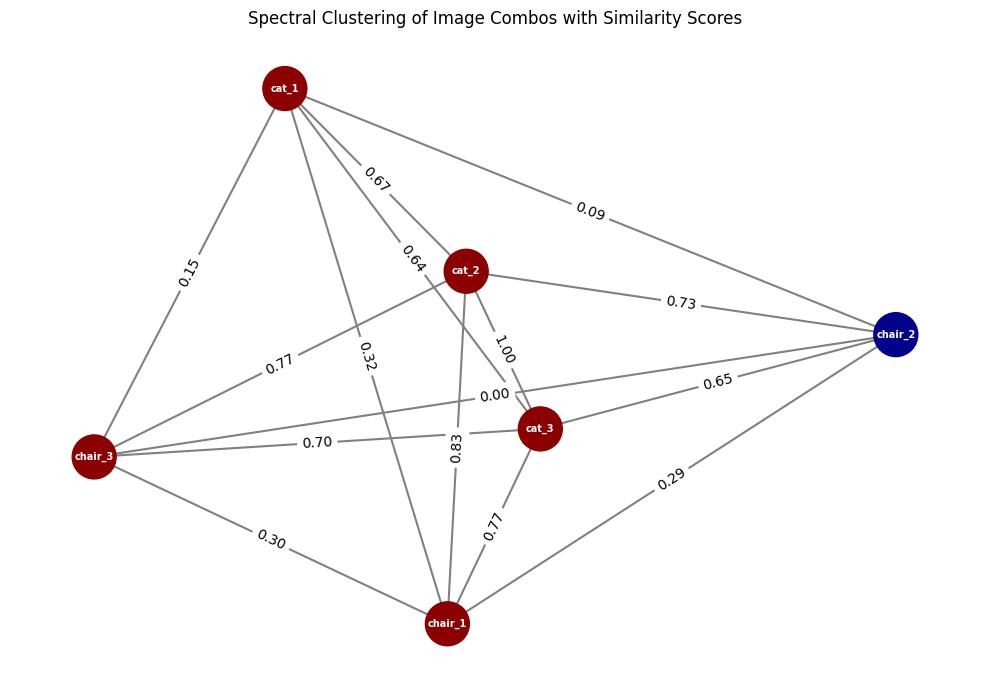

---

In [157]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/9j/r5f6j63x4rvch3_z626m_q3w0000gn/T/pip-req-build-rs1nxgi1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/9j/r5f6j63x4rvch3_z626m_q3w0000gn/T/pip-req-build-rs1nxgi1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached regex-2024.11.6-cp313-cp313-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached setuptools-80.1.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached regex-2024.11.6-cp313-cp313-macosx_11_0_arm64.whl (284 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━

In [158]:
!pip install open_clip_torch

  Using cached PyYAML-6.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.9 MB/s eta 0:00:00a 0:00:01
Using cached PyYAML-6.0.2-cp313-cp313-macosx_11_0_arm64.whl (171 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.1-cp313-cp313-macosx_10_13_universal2.whl (195 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [159]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 7.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.9 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [161]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


### CLIP-Based pre-trained model

In [21]:
import torch
import open_clip
from sentence_transformers import util
from PIL import Image

# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [22]:
image_files = sorted([f for f in os.listdir(image_set_3_dir) if f.endswith('.jpeg')])

def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1
def generateScore(image1, image2):
    test_img = image1
    data_img = image2
    img1 = imageEncoder(test_img)
    img2 = imageEncoder(data_img)
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score

img_dict = {}
for img_name in image_files:
    path = os.path.join(image_set_3_dir, img_name)

    # Read image
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    img_dict[img_name] = img

img1_list = []
img2_list = []
similarity = []
for (img_name_1, img_1), (img_name_2, img_2) in combinations(img_dict.items(), 2):
    img1_list.append(img_name_1.replace('.jpeg', ''))
    img2_list.append(img_name_2.replace('.jpeg', ''))
    similarity.append(np.round(generateScore(img_1, img_2), 2))

clip_df = pd.DataFrame(
    {
        'Pair1':img1_list,
        'Pair2':img2_list,
        'Similarity':similarity,
    }
)

clip_df.sort_values('Similarity', ascending=False)

Pair1    Pair2  Similarity
12  chair_1  chair_2       81.35
5     cat_2    cat_3       79.81
13  chair_1  chair_3       77.70
14  chair_2  chair_3       67.78
0     cat_1    cat_2       64.94
1     cat_1    cat_3       61.23
4     cat_1  chair_3       41.32
8     cat_2  chair_3       36.12
11    cat_3  chair_3       35.13
2     cat_1  chair_1       34.62
10    cat_3  chair_2       34.32
9     cat_3  chair_1       32.79
6     cat_2  chair_1       31.18
3     cat_1  chair_2       31.06
7     cat_2  chair_2       29.82

### Getting Features and Similarities using AutoModel

In [171]:
!pip install accelerate


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import torch
from PIL import Image
from transformers import pipeline
from accelerate.test_utils.testing import get_backend
from transformers import AutoImageProcessor, AutoModel
from torch.nn.functional import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

# automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
DEVICE, _, _ = get_backend()
pipe = pipeline(task="image-feature-extraction", model_name="google/vit-base-patch16-384", device=DEVICE, pool=True)

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use mps
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=Tr

In [17]:
def infer(image):
    inputs = processor(image, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    return outputs.pooler_output

img_dict = {}
for img_name in image_files:
    path = os.path.join(image_set_3_dir, img_name)

    # Read image
    img = Image.open(path)
    img_dict[img_name] = img

img1_list = []
img2_list = []
similarity = []
for (img_name_1, img_1), (img_name_2, img_2) in combinations(img_dict.items(), 2):
    img1_list.append(img_name_1.replace('.jpeg', ''))
    img2_list.append(img_name_2.replace('.jpeg', ''))
    
    embed_real = infer(img_1)
    embed_gen = infer(img_2)

    similarity_score = cosine_similarity(embed_real, embed_gen, dim=1)
    similarity.append(similarity_score.item())

automodel_df = pd.DataFrame(
    {
        'Pair1':img1_list,
        'Pair2':img2_list,
        'Similarity':similarity,
    }
)

automodel_df.sort_values('Similarity', ascending=False)

Pair1    Pair2  Similarity
5     cat_2    cat_3    0.677823
13  chair_1  chair_3    0.635060
12  chair_1  chair_2    0.583544
14  chair_2  chair_3    0.579090
0     cat_1    cat_2    0.445616
1     cat_1    cat_3    0.360261
10    cat_3  chair_2    0.303522
9     cat_3  chair_1    0.218837
11    cat_3  chair_3    0.180537
7     cat_2  chair_2    0.115988
2     cat_1  chair_1    0.104518
4     cat_1  chair_3    0.100650
3     cat_1  chair_2    0.079602
8     cat_2  chair_3    0.072327
6     cat_2  chair_1    0.068592

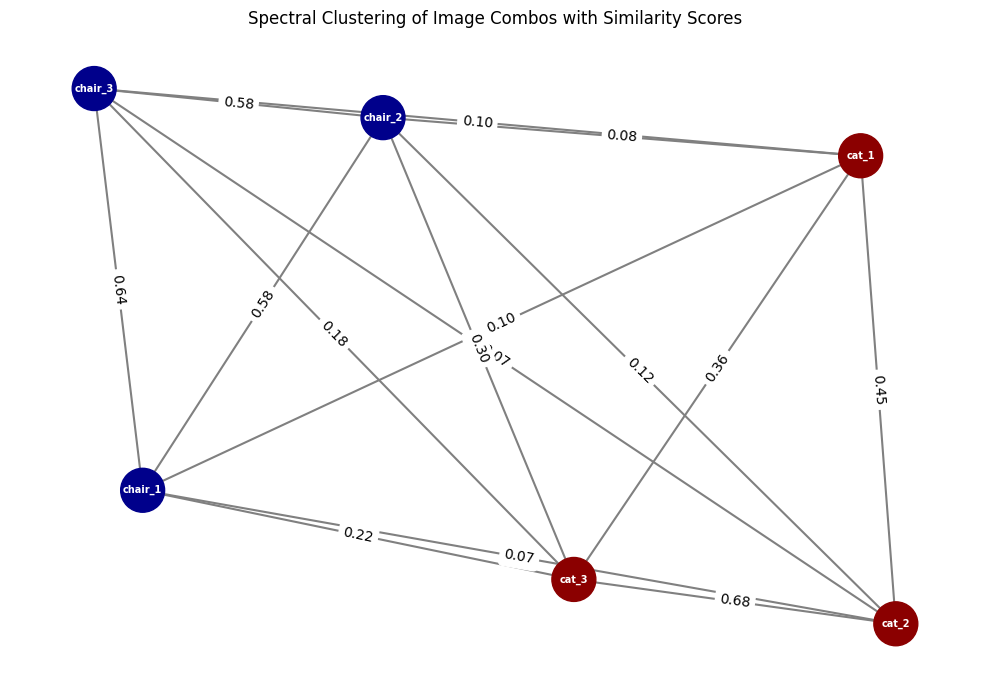

In [18]:
scaler = MinMaxScaler()
automodel_df['similarity_scaled'] = scaler.fit_transform(automodel_df[['Similarity']])

# Step 3: Build the graph
G = nx.Graph()
for _, row in automodel_df.iterrows():
    G.add_edge(row['Pair1'], row['Pair2'], weight=row['Similarity'])

# Step 4: Create adjacency matrix from graph
adj_matrix = nx.to_numpy_array(G, weight='weight', nodelist=sorted(G.nodes()))
nodes = sorted(G.nodes())

# Step 5: Spectral Clustering
sc = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42)
labels = sc.fit_predict(adj_matrix)

# Create a color map for clusters
color_map = ['darkred' if label == 0 else 'darkblue' for label in labels]

# Generate positions for each node (spring layout)
pos = nx.spring_layout(G, seed=42)

# Draw the nodes and edges
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1_000)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5)
nx.draw_networkx_labels(G, pos, font_size=7, font_color='white', font_weight='bold')

# Draw edge weights (similarities)
edge_labels = nx.get_edge_attributes(G, 'weight')
# Format edge labels to 2 decimal places
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

plt.title('Spectral Clustering of Image Combos with Similarity Scores')
plt.axis('off')
plt.tight_layout()
plt.show()

In [2]:
pip install python-louvain

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9458 sha256=8cfc77e2bae9742a648a5dc909cdf25ab17072c72228bcbd77eff54dd626f2d5
  Stored in directory: /Users/franco/Library/Caches/pip/wheels/ee/52/54/7ecd0f1ebf5f5a8466f70a27ed2b94d20b955376879d6159c5
Successfully built python-louvain

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import community as community_louvain 
# Step 4: Build graph with similarity weights
G = nx.Graph()
for _, row in clip_df.iterrows():
    G.add_edge(row['Pair1'], row['Pair2'], weight=row['Similarity'])

# Step 5: Run Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')  # returns dict: node -> community

# Step 6: Convert result to DataFrame
cluster_df = pd.DataFrame(list(partition.items()), columns=['Node', 'Community']).sort_values(by='Node')
cluster_df

Node  Community
0    cat_1          0
1    cat_2          0
2    cat_3          0
3  chair_1          1
4  chair_2          1
5  chair_3          1